Library

In [43]:
#import libraries

import pandas as pd
import yfinance as yf
import plotly.express as px
import os
import warnings

from datetime import datetime, timedelta
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly
from dotenv import load_dotenv

import datapane as dp


In [44]:
warnings.filterwarnings("ignore")
pd.options.display.float_format = "${:,.2f}".format

load_dotenv()
API_TOKEN = os.environ.get("API_KEY")
dp.login(API_TOKEN) #Insert APIKey

Connected successfully to https://datapane.com as mymy131311@live.com.sg


'mymy131311@live.com.sg'

Get ETH Data

In [45]:
today = datetime.today().strftime("%Y-%m-%d")
start_date = "2016-01-01"

# Using Pandas dataframe
eth_df = yf.download("ETH-USD", start_date, today)

# Load the 10 latest entries
eth_df.tail()

# Tags: Date, Open, High, Low, Close, Adj Close, Volume

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-02-11,"$1,514.94","$1,541.33","$1,510.15","$1,539.93","$1,539.93",5064007416
2023-02-12,"$1,539.78","$1,545.55","$1,501.46","$1,515.03","$1,515.03",5319698775
2023-02-13,"$1,514.92","$1,524.73","$1,470.02","$1,507.17","$1,507.17",9363855114
2023-02-14,"$1,506.99","$1,562.03","$1,497.19","$1,556.88","$1,556.88",9249575045
2023-02-15,"$1,556.77","$1,674.29","$1,545.69","$1,673.75","$1,673.75",10015035156


Analysis of ETH Data

In [46]:
# Summarise datapoints and datatype for each column and memory usage
eth_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1925 entries, 2017-11-09 to 2023-02-15
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1925 non-null   float64
 1   High       1925 non-null   float64
 2   Low        1925 non-null   float64
 3   Close      1925 non-null   float64
 4   Adj Close  1925 non-null   float64
 5   Volume     1925 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 105.3 KB


In [47]:
# Check for missing (null) values
eth_df.isnull().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [48]:
# Separate features into categorical and numerical
cat_df = eth_df.select_dtypes(include=["object"]) #categorical
num_df = eth_df.select_dtypes(exclude=["object"]) #numerical

def printColumnTypes(catdf, numdf):
    print("Categorical columns: ")
    for col in catdf:
        print(f"{col}")
    print("Numerical columns: ")
    for col in numdf:
        print(f"{col}")
        
printColumnTypes(cat_df, num_df)

Categorical columns: 
Numerical columns: 
Open
High
Low
Close
Adj Close
Volume


In [49]:
# Notice missing date column
eth_df.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

In [50]:
# Reset index to have missing date column
eth_df = eth_df.reset_index()

eth_df.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

In [51]:
# Note to self on limitation of prophet library
# Only allowed to have 2 columns in dataframe - "ds" & "y"
df = eth_df[["Date", "Open"]]

new_names = {
    "Date": "ds",
    "Open": "y"
}

df.rename(columns=new_names, inplace=True)

In [52]:
df.tail()

,ds,y
1920,2023-02-11,"$1,514.94"
1921,2023-02-12,"$1,539.78"
1922,2023-02-13,"$1,514.92"
1923,2023-02-14,"$1,506.99"
1924,2023-02-15,"$1,556.77"


In [53]:
# plot the open price
x = df["ds"]
y = df["y"]

fig = px.line(df, x=x, y=y, title="Time series plot of Ethereum Open Price")

fig.update_layout(
    xaxis=dict(
        rangeselector=dict(
            buttons=list(
                [
                    dict(count=1, label="1m", step="month", stepmode="backward"),
                    dict(count=6, label="6m", step="month", stepmode="backward"),
                    dict(count=1, label="YTD", step="year", stepmode="todate"),
                    dict(count=1, label="1y", step="year", stepmode="backward"),
                    dict(step="all"),
                ]
            )
        ),
        rangeslider=dict(visible=True),
        type="date",
    )
)
fig.show()

Prophet Model (Simple)

In [54]:
m = Prophet()
m.fit(df)

19:41:17 - cmdstanpy - INFO - Chain [1] start processing
19:41:18 - cmdstanpy - INFO - Chain [1] done processing


In [55]:
future = m.make_future_dataframe(periods = 30)
future.tail()

,ds
1950,2023-03-13
1951,2023-03-14
1952,2023-03-15
1953,2023-03-16
1954,2023-03-17


In [56]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1950,2023-03-13,$585.97,$221.19,$959.81
1951,2023-03-14,$584.37,$221.50,$930.17
1952,2023-03-15,$584.57,$213.92,$948.58
1953,2023-03-16,$585.24,$186.06,$952.37
1954,2023-03-17,$582.65,$203.06,$944.87


In [57]:
# Get prediction for next day
next_day = (datetime.today() + timedelta(days=1)).strftime('%Y-%m-%d')
forecast[forecast['ds'] == next_day]['yhat'].item()

892.4559466617477

Forecast Plots

In [58]:
fig1 = plot_plotly(m, forecast)

In [59]:
fig2 = plot_components_plotly(m, forecast)

Export graphs as datapanes for markdown

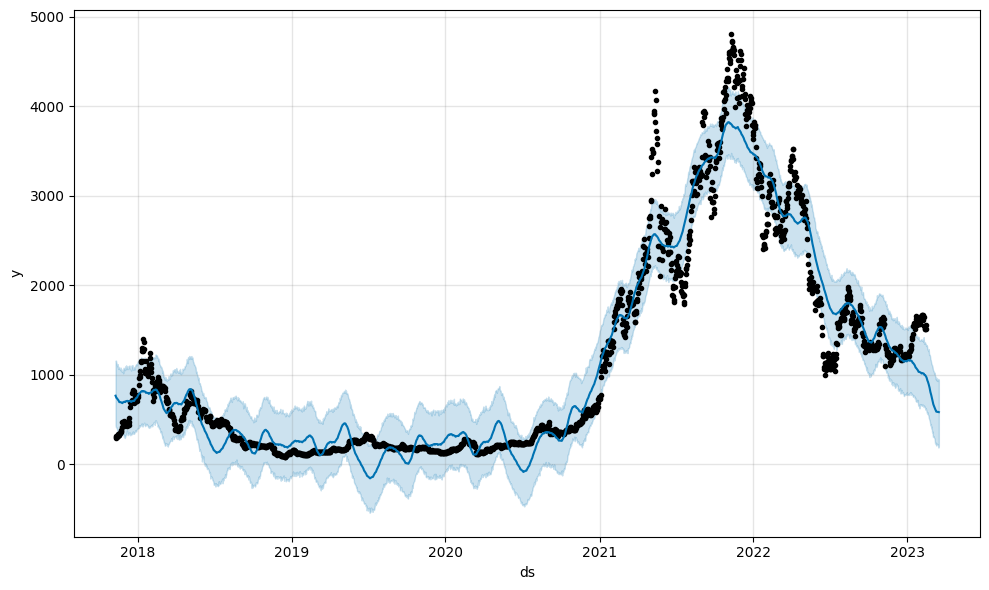

In [60]:
#Export as svg
simplefig = m.plot(forecast)
simplefig.savefig('prophetplot.svg')

In [61]:
# Template for exporting to datapane
# upload & open report in the browser
# dp.Report(dp.Plot(fig)).upload(name="Time series plot of Ethereum Open Price", publicly_visible=True, open=True)
# dp.Report(dp.Plot(fig1)).upload(name="ETH Price Forecast", publicly_visible=True, open=True)
# dp.Report(dp.Plot(fig2)).upload(name="ETH Price Components", publicly_visible=True, open=True)